<a href="https://colab.research.google.com/github/i-ganza007/Kuiper_Summative/blob/main/training/Reinforce/RE_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium pygame seaborn

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns
import pandas as pd
import json
import time
import pygame
from typing import List, Dict, Tuple

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print(" All imports completed!")

 All imports completed!


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
import os
OUTPUT_DIR = "/kaggle/working"
LOG_DIR = f"{OUTPUT_DIR}/logs/reinforce/"
CHECKPOINT_DIR = f"{OUTPUT_DIR}/checkpoints_reinforce/"
RESULTS_DIR = f"{OUTPUT_DIR}/results_reinforce/"

for d in [LOG_DIR, CHECKPOINT_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("REINFORCE TRAINING - MISSION ENVIRONMENT")
print(f"Output Directory: {OUTPUT_DIR}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


REINFORCE TRAINING - MISSION ENVIRONMENT
Output Directory: /kaggle/working
Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


In [ ]:
class MissionEnvironment(gym.Env):
    """Custom Mission Environment with grid-based tasks"""

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, grid_size=10, num_missions=3, render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.num_missions = num_missions
        self.render_mode = render_mode

        self.action_space = spaces.Discrete(5)

        obs_size = 4 + (num_missions * 3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0] + [0, -grid_size, -grid_size] * num_missions, dtype=np.float32),
            high=np.array([grid_size, grid_size, 200, num_missions] + [np.sqrt(2*grid_size**2), grid_size, grid_size] * num_missions, dtype=np.float32),
            dtype=np.float32
        )

        self.agent_pos = None
        self.missions = None
        self.completed_missions = None
        self.fuel = 200
        self.max_fuel = 200
        self.steps = 0
        self.max_steps = 500
        self.window = None
        self.clock = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = np.array(
            [self.np_random.integers(0, self.grid_size),
             self.np_random.integers(0, self.grid_size)],
            dtype=np.int32
        )
        self.missions = []
        for _ in range(self.num_missions):
            while True:
                mission = np.array(
                    [self.np_random.integers(0, self.grid_size),
                     self.np_random.integers(0, self.grid_size)],
                    dtype=np.int32
                )
                if not np.array_equal(mission, self.agent_pos) and \
                   not any(np.array_equal(mission, m) for m in self.missions):
                    self.missions.append(mission)
                    break
        self.completed_missions = np.zeros(self.num_missions, dtype=bool)
        self.fuel = self.max_fuel
        self.steps = 0
        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros(4 + self.num_missions * 3, dtype=np.float32)
        obs[0] = float(self.agent_pos[0])
        obs[1] = float(self.agent_pos[1])
        obs[2] = float(self.fuel)
        obs[3] = float(np.sum(self.completed_missions))

        mission_idx = 0
        for i in range(self.num_missions):
            if not self.completed_missions[i]:
                dx = float(self.missions[i][0] - self.agent_pos[0])
                dy = float(self.missions[i][1] - self.agent_pos[1])
                dist = np.sqrt(dx**2 + dy**2)
                obs[4 + mission_idx*3] = dist
                obs[4 + mission_idx*3 + 1] = dx
                obs[4 + mission_idx*3 + 2] = dy
            else:
                obs[4 + mission_idx*3] = 0.0
                obs[4 + mission_idx*3 + 1] = 0.0
                obs[4 + mission_idx*3 + 2] = 0.0
            mission_idx += 1

        return obs

    def step(self, action):
        self.steps += 1
        reward = -0.1
        terminated = False
        truncated = self.steps >= self.max_steps

        if action < 4:
            if self.fuel > 0:
                deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
                new_pos = self.agent_pos + np.array(deltas, dtype=np.int32)

                if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                    self.agent_pos = new_pos
                    self.fuel -= 1

                    active_mission_indices = [i for i in range(self.num_missions)
                                            if not self.completed_missions[i]]
                    if active_mission_indices:
                        distances = [np.linalg.norm(self.agent_pos.astype(float) - self.missions[i].astype(float))
                                   for i in active_mission_indices]
                        min_dist = np.min(distances)
                        reward += 2.0 / (1.0 + min_dist)
                else:
                    reward -= 0.2
            else:
                reward -= 0.1

        elif action == 4:
            mission_completed = False
            for i, mission in enumerate(self.missions):
                if not self.completed_missions[i] and np.array_equal(self.agent_pos, mission):
                    self.completed_missions[i] = True
                    reward += 200.0
                    mission_completed = True
                    self.fuel = min(self.max_fuel, self.fuel + 30)
                    break

            if not mission_completed:
                reward -= 0.5

        completed_count = np.sum(self.completed_missions)
        if completed_count == self.num_missions:
            reward += 500.0
            reward += self.fuel * 0.5
            terminated = True

        if self.fuel <= 0 and not terminated:
            reward -= 10.0
            terminated = True

        if truncated and not terminated:
            reward -= 5.0

        return self._get_observation(), reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            return
        if self.window is None and self.render_mode == "human":
            import pygame
            pygame.init()
            self.window = pygame.display.set_mode((600, 600))
            self.clock = pygame.time.Clock()

        import pygame
        canvas = pygame.Surface((600, 600))
        canvas.fill((255, 255, 255))
        pix = 600 / self.grid_size

        for i, m in enumerate(self.missions):
            color = (100, 200, 100) if self.completed_missions[i] else (200, 100, 100)
            pygame.draw.rect(canvas, color, (m[0]*pix, m[1]*pix, pix, pix))

        pygame.draw.circle(canvas, (0, 0, 255),
                          ((self.agent_pos[0]+0.5)*pix, (self.agent_pos[1]+0.5)*pix),
                          pix/3)

        for x in range(self.grid_size + 1):
            pygame.draw.line(canvas, (200, 200, 200), (x*pix, 0), (x*pix, 600))
            pygame.draw.line(canvas, (200, 200, 200), (0, x*pix), (600, x*pix))

        if self.render_mode == "human":
            self.window.blit(canvas, (0, 0))
            pygame.display.flip()
            self.clock.tick(30)

    def close(self):
        if self.window:
            import pygame
            pygame.quit()
            self.window = None

gym.register(id="MissionEnv-v0", entry_point="__main__:MissionEnvironment", max_episode_steps=500)
print(" MissionEnvironment registered!\n")

 MissionEnvironment registered!



In [ ]:
class PolicyNetwork(nn.Module):
    """Neural network for REINFORCE policy"""

    def __init__(self, state_dim, action_dim, hidden_dims=[256, 128]):
        super(PolicyNetwork, self).__init__()

        layers = []
        input_dim = state_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            input_dim = hidden_dim

        self.network = nn.Sequential(*layers)
        self.action_head = nn.Linear(input_dim, action_dim)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=0.01)
            nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = self.network(x)
        action_scores = self.action_head(x)
        return F.softmax(action_scores, dim=-1)

print(" Policy Network defined!\n")

 Policy Network defined!



In [ ]:
class REINFORCE:
    """
    REINFORCE Algorithm (Monte Carlo Policy Gradient)
    """

    def __init__(self, state_dim, action_dim, config):
        self.config = config
        self.device = torch.device(DEVICE)

        self.policy = PolicyNetwork(state_dim, action_dim, config['hidden_dims']).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(),
                                  lr=config['learning_rate'],
                                  weight_decay=config.get('weight_decay', 0.0))

        self.saved_log_probs = []
        self.rewards = []
        self.entropies = []

        self.episode_rewards = []
        self.episode_lengths = []

    def select_action(self, state):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        probs = self.policy(state)
        m = Categorical(probs)
        action = m.sample()

        self.saved_log_probs.append(m.log_prob(action))
        self.entropies.append(m.entropy())

        return action.item()

    def compute_returns(self, rewards, normalize=True):
        """Compute discounted returns"""
        returns = []
        G = 0

        for r in reversed(rewards):
            G = r + self.config['gamma'] * G
            returns.insert(0, G)

        returns = torch.tensor(returns, device=self.device)

        if normalize:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        return returns

    def update_policy(self):
        """Update policy using REINFORCE gradient"""
        returns = self.compute_returns(self.rewards, self.config.get('normalize_returns', True))

        policy_loss = []
        for log_prob, G in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * G)

        entropy_loss = -torch.stack(self.entropies).mean() * self.config.get('entropy_coef', 0.01)

        loss = torch.stack(policy_loss).sum() + entropy_loss

        self.optimizer.zero_grad()
        loss.backward()

        if self.config.get('max_grad_norm'):
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.config['max_grad_norm'])

        self.optimizer.step()

        self.saved_log_probs = []
        self.rewards = []
        self.entropies = []

        return loss.item()

    def save_checkpoint(self, path):
        """Save model checkpoint"""
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config
        }, path)

    def load_checkpoint(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(" REINFORCE Algorithm defined!\n")

 REINFORCE Algorithm defined!



In [ ]:
CONFIG_REINFORCE = {
         "learning_rate": 0.0015,
        "gamma": 0.98,
        "hidden_dims": [384, 192, 96],
        "entropy_coef": 0.03,
        "normalize_returns": True,
        "max_grad_norm": 0.7,
        "weight_decay": 0.0003,
        "total_episodes": 2000,
        "checkpoint_freq": 500
}

print("REINFORCE Configuration:")
for key, val in CONFIG_REINFORCE.items():
    print(f"  {key}: {val}")
print()

REINFORCE Configuration:
  learning_rate: 0.0015
  gamma: 0.98
  hidden_dims: [384, 192, 96]
  entropy_coef: 0.03
  normalize_returns: True
  max_grad_norm: 0.7
  weight_decay: 0.0003
  total_episodes: 2000
  checkpoint_freq: 500



In [ ]:
class TrainingMetrics:
    """Comprehensive training metrics tracking"""

    def __init__(self):
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_losses = []
        self.missions_completed = []
        self.successes = []
        self.timesteps = []
        self.start_time = time.time()

    def update(self, episode_reward, episode_length, loss, completed_missions, timestep):
        """Update metrics after each episode"""
        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(episode_length)
        self.episode_losses.append(loss)
        self.missions_completed.append(completed_missions)
        self.successes.append(1 if completed_missions == 3 else 0)
        self.timesteps.append(timestep)

    def get_summary_stats(self, window=100):
        """Get summary statistics"""
        if len(self.episode_rewards) == 0:
            return {}

        recent_rewards = self.episode_rewards[-window:]
        recent_lengths = self.episode_lengths[-window:]
        recent_successes = self.successes[-window:]

        return {
            'mean_reward': np.mean(recent_rewards),
            'std_reward': np.std(recent_rewards),
            'mean_steps': np.mean(recent_lengths),
            'success_rate': np.mean(recent_successes) * 100,
            'total_episodes': len(self.episode_rewards),
            'training_time': time.time() - self.start_time
        }

    def save_to_file(self, filepath):
        """Save metrics to JSON file"""
        data = {
            'episode_rewards': self.episode_rewards,
            'episode_lengths': self.episode_lengths,
            'episode_losses': self.episode_losses,
            'missions_completed': self.missions_completed,
            'successes': self.successes,
            'timesteps': self.timesteps,
            'summary_stats': self.get_summary_stats()
        }

        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)

print(" Training Metrics defined!\n")

 Training Metrics defined!



In [ ]:

def train_reinforce(config, env):
    """Main training function for REINFORCE"""

    print("STARTING REINFORCE TRAINING")
    print(f"Total Episodes: {config['total_episodes']:,}\n")

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = REINFORCE(state_dim, action_dim, config)
    metrics = TrainingMetrics()

    start_time = time.time()

    for episode in range(1, config['total_episodes'] + 1):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.rewards.append(reward)
            episode_reward += reward
            episode_length += 1
            state = next_state

        loss = agent.update_policy()

        completed_missions = int(state[3])

        metrics.update(episode_reward, episode_length, loss, completed_missions, episode)

        if episode % config['checkpoint_freq'] == 0:
            checkpoint_path = f"{CHECKPOINT_DIR}reinforce_episode_{episode}.pth"
            agent.save_checkpoint(checkpoint_path)

        if episode % 100 == 0 or episode == config['total_episodes']:
            stats = metrics.get_summary_stats(window=100)
            print(f"Episode {episode:4d}/{config['total_episodes']} | "
                  f"Reward: {episode_reward:7.2f} | "
                  f"Avg Reward: {stats['mean_reward']:6.2f} | "
                  f"Success: {stats['success_rate']:5.1f}% | "
                  f"Loss: {loss:.4f}")

    training_time = time.time() - start_time

    print("REINFORCE TRAINING COMPLETED!")
    print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    return agent, metrics

env = MissionEnvironment()
print(f" Environment created: {env.observation_space.shape} -> {env.action_space.n} actions\n")

 Environment created: (13,) -> 5 actions



In [ ]:
agent, metrics = train_reinforce(CONFIG_REINFORCE, env)

final_model_path = f"{OUTPUT_DIR}/reinforce_seventh.pth"
agent.save_checkpoint(final_model_path)
print(f" Final model saved: {final_model_path}")

metrics_path = f"{RESULTS_DIR}/reinforce_metrics.json"
metrics.save_to_file(metrics_path)
print(f" Metrics saved: {metrics_path}")

STARTING REINFORCE TRAINING
Total Episodes: 2,000

Episode  100/2000 | Reward:  266.80 | Avg Reward: 220.89 | Success:   4.0% | Loss: -10.2387
Episode  200/2000 | Reward:   78.39 | Avg Reward: 121.66 | Success:   0.0% | Loss: -9.4340
Episode  300/2000 | Reward:  301.36 | Avg Reward: 147.73 | Success:   1.0% | Loss: -0.2967
Episode  400/2000 | Reward:   91.09 | Avg Reward:  87.45 | Success:   0.0% | Loss: -33.0039
Episode  500/2000 | Reward:  521.17 | Avg Reward: 150.86 | Success:   1.0% | Loss: -3.4627
Episode  600/2000 | Reward:  100.24 | Avg Reward: 200.14 | Success:   1.0% | Loss: -27.1319
Episode  700/2000 | Reward:  116.29 | Avg Reward: 224.31 | Success:   4.0% | Loss: -37.9681
Episode  800/2000 | Reward:   88.87 | Avg Reward: 187.01 | Success:   0.0% | Loss: -12.6509
Episode  900/2000 | Reward:  150.48 | Avg Reward: 249.16 | Success:   4.0% | Loss: -77.1389
Episode 1000/2000 | Reward:  494.17 | Avg Reward: 148.45 | Success:   0.0% | Loss: -28.3426
Episode 1100/2000 | Reward:   54

In [ ]:
def evaluate_reinforce(agent, num_episodes=50):
    """Evaluate trained REINFORCE agent"""

    print(f"\nEvaluating REINFORCE on {num_episodes} episodes...")

    eval_env = MissionEnvironment()
    total_rewards = []
    success_count = 0
    episode_lengths = []

    for ep in range(num_episodes):
        state, _ = eval_env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action = agent.select_action(state)
            state, reward, terminated, truncated, _ = eval_env.step(action)
            episode_reward += reward
            episode_length += 1
            done = terminated or truncated

        total_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        completed_missions = int(state[3])
        if completed_missions == 3:
            success_count += 1

        if (ep + 1) % 10 == 0:
            print(f"  Episode {ep+1:2d}: Reward={episode_reward:7.2f}, "
                  f"Missions={completed_missions}/3")

    eval_env.close()

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    success_rate = (success_count / num_episodes) * 100
    avg_length = np.mean(episode_lengths)

    print(f"\n Evaluation Results:")
    print(f"  Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"  Success Rate: {success_rate:.1f}%")
    print(f"  Avg Episode Length: {avg_length:.1f} steps")

    return {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'success_rate': success_rate,
        'avg_length': avg_length,
        'all_rewards': total_rewards
    }

eval_results = evaluate_reinforce(agent, num_episodes=50)


Evaluating REINFORCE on 50 episodes...
  Episode 10: Reward=  50.72, Missions=0/3
  Episode 20: Reward=  26.80, Missions=0/3
  Episode 30: Reward=  59.43, Missions=0/3
  Episode 40: Reward= 293.63, Missions=1/3
  Episode 50: Reward= 115.98, Missions=0/3

 Evaluation Results:
  Mean Reward: 124.25 ± 80.18
  Success Rate: 0.0%
  Avg Episode Length: 212.9 steps


Saved visualization: /kaggle/working/reinforce_training_results.png


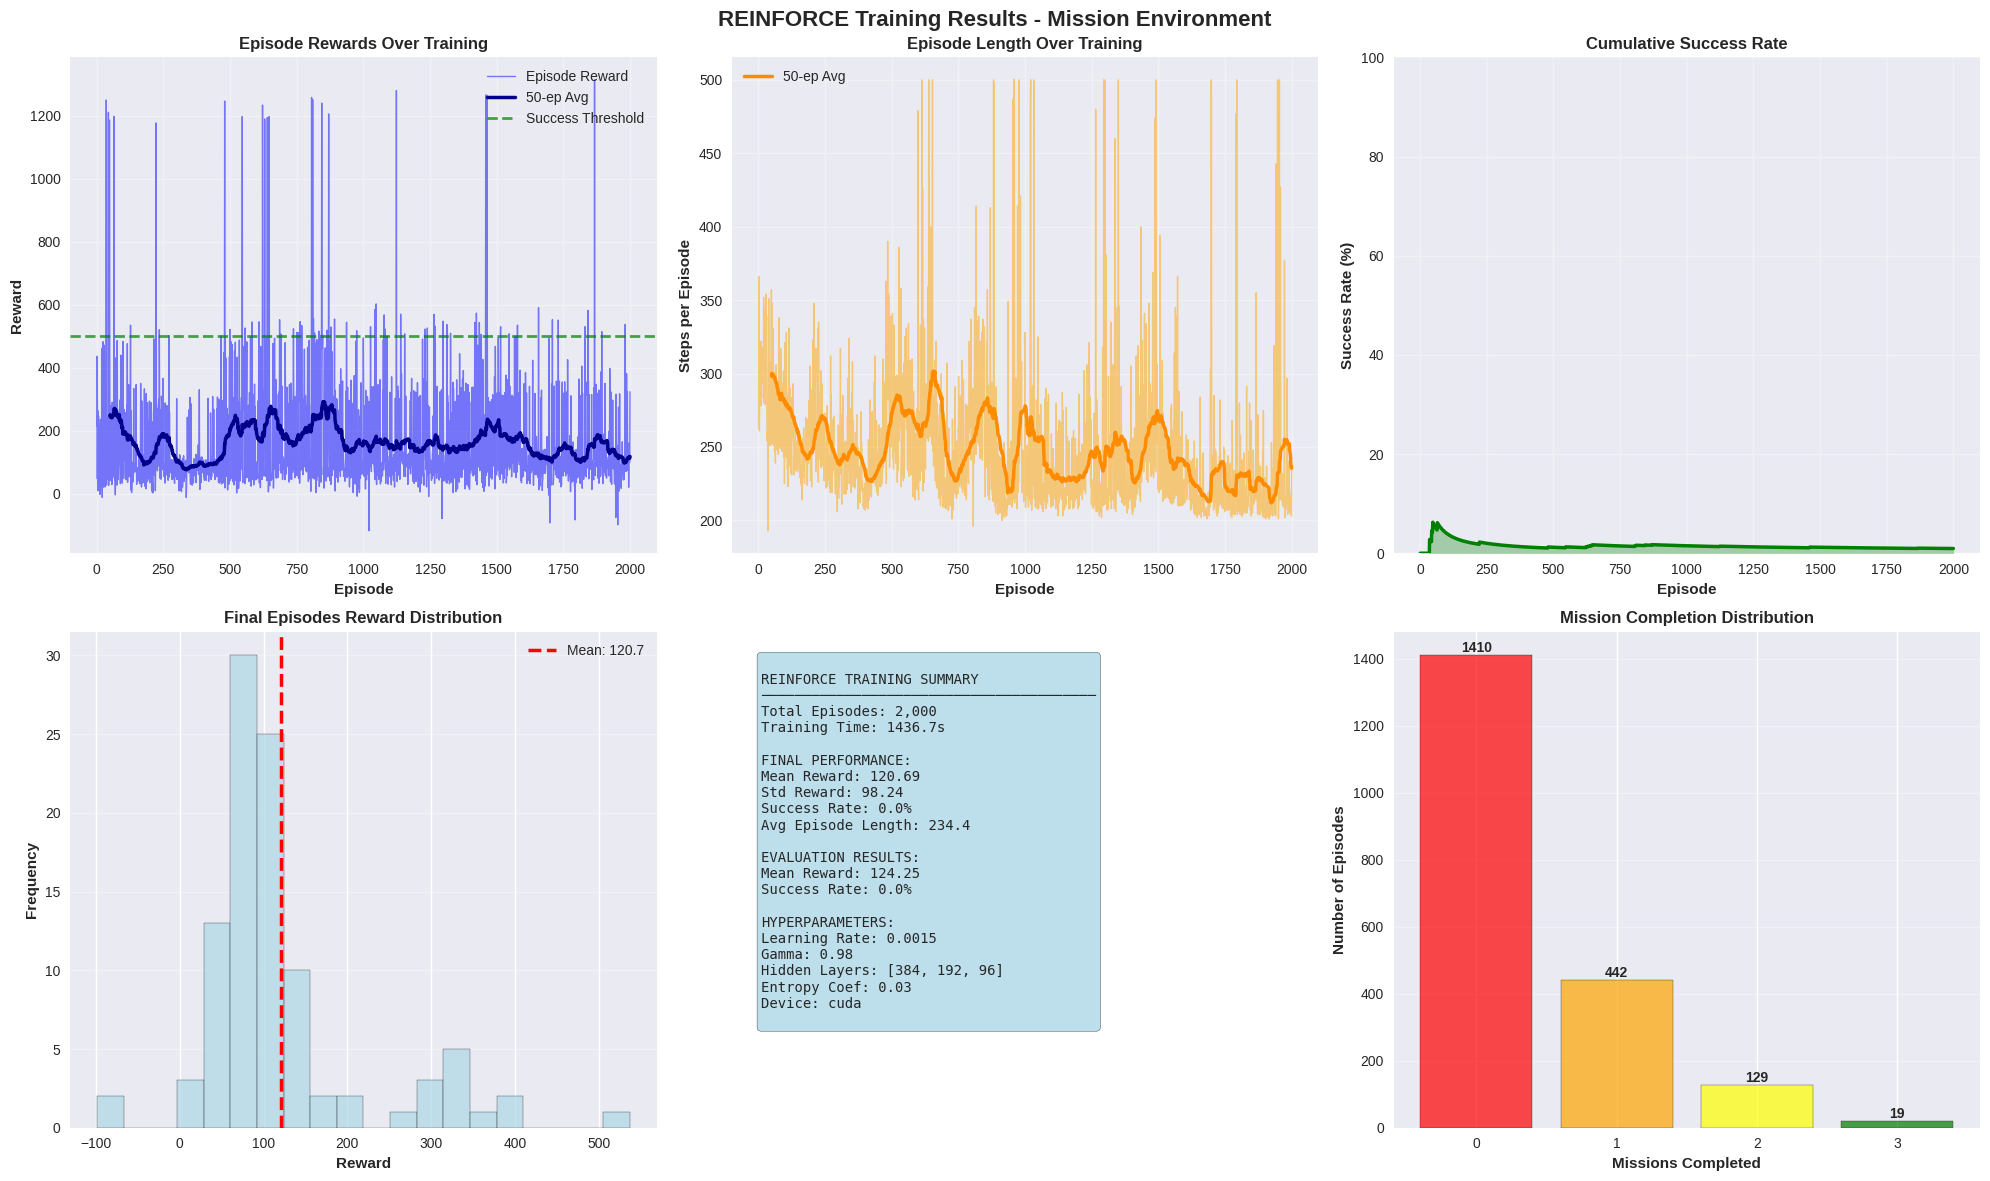

In [ ]:
def create_training_visualization(metrics, eval_results, config):
    """Create comprehensive training visualization"""

    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('REINFORCE Training Results - Mission Environment',
                 fontsize=16, fontweight='bold', y=0.98)

    episodes = range(1, len(metrics.episode_rewards) + 1)
    rewards = np.array(metrics.episode_rewards)
    lengths = np.array(metrics.episode_lengths)
    successes = np.array(metrics.successes)

    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(episodes, rewards, alpha=0.5, label='Episode Reward', linewidth=1, color='blue')
    if len(rewards) > 50:
        rolling = np.convolve(rewards, np.ones(50)/50, mode='valid')
        ax1.plot(episodes[49:], rolling, linewidth=2.5, label='50-ep Avg', color='darkblue')
    ax1.axhline(y=500, color='g', linestyle='--', linewidth=2, alpha=0.7, label='Success Threshold')
    ax1.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Reward', fontsize=11, fontweight='bold')
    ax1.set_title('Episode Rewards Over Training', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(episodes, lengths, alpha=0.5, color='orange', linewidth=1)
    if len(lengths) > 50:
        rolling_len = np.convolve(lengths, np.ones(50)/50, mode='valid')
        ax2.plot(episodes[49:], rolling_len, linewidth=2.5, color='darkorange', label='50-ep Avg')
    ax2.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Steps per Episode', fontsize=11, fontweight='bold')
    ax2.set_title('Episode Length Over Training', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    cum_success = np.cumsum(successes)
    success_pct = (cum_success / np.arange(1, len(cum_success)+1)) * 100
    ax3.plot(episodes, success_pct, linewidth=2.5, color='green')
    ax3.fill_between(episodes, 0, success_pct, alpha=0.3, color='green')
    ax3.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Success Rate (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Cumulative Success Rate', fontsize=12, fontweight='bold')
    ax3.set_ylim([0, 100])
    ax3.grid(True, alpha=0.3)

    ax4 = plt.subplot(2, 3, 4)
    final_rewards = rewards[-min(100, len(rewards)):]
    ax4.hist(final_rewards, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
    ax4.axvline(np.mean(final_rewards), color='red', linestyle='--', linewidth=2.5,
               label=f'Mean: {np.mean(final_rewards):.1f}')
    ax4.set_xlabel('Reward', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax4.set_title('Final Episodes Reward Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')

    stats = metrics.get_summary_stats()
    final_success_rate = np.mean(successes[-100:]) * 100 if len(successes) > 100 else np.mean(successes) * 100

    summary_text = f"""
REINFORCE TRAINING SUMMARY
{'─'*40}
Total Episodes: {config['total_episodes']:,}
Training Time: {stats['training_time']:.1f}s

FINAL PERFORMANCE:
Mean Reward: {stats['mean_reward']:.2f}
Std Reward: {stats['std_reward']:.2f}
Success Rate: {final_success_rate:.1f}%
Avg Episode Length: {stats['mean_steps']:.1f}

EVALUATION RESULTS:
Mean Reward: {eval_results['mean_reward']:.2f}
Success Rate: {eval_results['success_rate']:.1f}%

HYPERPARAMETERS:
Learning Rate: {config['learning_rate']}
Gamma: {config['gamma']}
Hidden Layers: {config['hidden_dims']}
Entropy Coef: {config['entropy_coef']}
Device: {DEVICE}
"""

    ax5.text(0.05, 0.95, summary_text, fontsize=10, family='monospace',
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    ax6 = plt.subplot(2, 3, 6)
    mission_counts = [metrics.missions_completed.count(i) for i in range(4)]
    colors = ['red', 'orange', 'yellow', 'green']
    bars = ax6.bar(range(4), mission_counts, color=colors, alpha=0.7, edgecolor='black')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    ax6.set_xlabel('Missions Completed', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Number of Episodes', fontsize=11, fontweight='bold')
    ax6.set_title('Mission Completion Distribution', fontsize=12, fontweight='bold')
    ax6.set_xticks(range(4))
    ax6.set_xticklabels(['0', '1', '2', '3'])
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    output_path = f"{OUTPUT_DIR}/reinforce_training_results.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization: {output_path}")
    plt.show()

create_training_visualization(metrics, eval_results, CONFIG_REINFORCE)